In [10]:

try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import torch.nn.functional as F
import pickle
import json
import os
import numpy as np
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=ce0136754ec5e877167ab4238f5b1920e85d485bcf693bf4486f215b3e9edf94
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=56e4f337003d8ac139cd749f5b7bbc886193aaf8000889b1cba47a1cc1105896
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
device = torch.device("cuda")
print('Done')

Done


In [3]:
def get_stadium_data():
  with open('/kaggle/input/baseball-field-images-masks/data.pkl', 'rb') as f:
      data = pickle.load(f)
  sort_dict = lambda x: [item[1] for item in sorted(x.items())]
  return np.array(sort_dict(data['images'])), np.array(sort_dict(data['masks'])), sorted(data['images'].keys())

In [4]:
def convert_to_tf_shape(X):
    return np.transpose(X, (0,2,3,1))

def convert_to_pt_shape(X):
    return np.transpose(X, (0,3,1,2))

In [5]:
X,y, park_names = get_stadium_data()
X = convert_to_pt_shape(X)
y = convert_to_pt_shape(y)
train_map = [True] * len(X)
for field in ['mccann_baseball_field', 'fenway_park', 'ken_walker_field', 
        'coors_field', 'hotto_motto_field_kobe', 'dunkin_park', 'louisville_slugger_field']:
    train_map[park_names.index(field)] = False

In [6]:
len(X[train_map])

122

In [14]:
# Define the model
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",    # Pre-trained on ImageNet
    in_channels=3,                 # Input channels (RGB)
    classes=4                      # Number of output classes
).to(device)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss for categorical outputs

# Create DataLoaders for training and validation
train_dataset = TensorDataset(torch.tensor(X[train_map]), torch.tensor(y[train_map]))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X[~np.array(train_map)]), torch.tensor(y[~np.array(train_map)]))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training loop
losses = []
epoch = 1
while epoch <= 200 and (len(losses)<5 or not np.allclose(losses[-5:-1], losses[-4:], atol=0.0001)):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loss_value = train_loss/len(train_loader)
        losses.append(loss_value)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # No need to compute gradients for validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
    
    # Calculate average validation loss
    val_loss_value = val_loss / len(val_loader)
    
    print(f"Epoch {epoch}, Loss: {loss_value:.4f}, Val Loss: {val_loss_value:.4f}")
    epoch += 1


Epoch 1, Loss: 1.8260, Val Loss: 2.3779
Epoch 2, Loss: 1.4349, Val Loss: 2.0372
Epoch 3, Loss: 1.2003, Val Loss: 1.4916
Epoch 4, Loss: 1.0368, Val Loss: 1.2283
Epoch 5, Loss: 0.9165, Val Loss: 1.1892
Epoch 6, Loss: 0.8154, Val Loss: 1.1638
Epoch 7, Loss: 0.7312, Val Loss: 1.0797
Epoch 8, Loss: 0.6725, Val Loss: 1.0201
Epoch 9, Loss: 0.6200, Val Loss: 0.8257
Epoch 10, Loss: 0.5763, Val Loss: 0.7198
Epoch 11, Loss: 0.5426, Val Loss: 0.6423
Epoch 12, Loss: 0.5085, Val Loss: 0.5938
Epoch 13, Loss: 0.4770, Val Loss: 0.5293
Epoch 14, Loss: 0.4507, Val Loss: 0.4944
Epoch 15, Loss: 0.4243, Val Loss: 0.4675
Epoch 16, Loss: 0.4028, Val Loss: 0.4502
Epoch 17, Loss: 0.3790, Val Loss: 0.4166
Epoch 18, Loss: 0.3554, Val Loss: 0.3866
Epoch 19, Loss: 0.3350, Val Loss: 0.3885
Epoch 20, Loss: 0.3144, Val Loss: 0.3511
Epoch 21, Loss: 0.2972, Val Loss: 0.3355
Epoch 22, Loss: 0.2795, Val Loss: 0.3430
Epoch 23, Loss: 0.2632, Val Loss: 0.3113
Epoch 24, Loss: 0.2507, Val Loss: 0.2922
Epoch 25, Loss: 0.2398, V

In [15]:
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [9]:
predictions[0].shape

(512, 512)

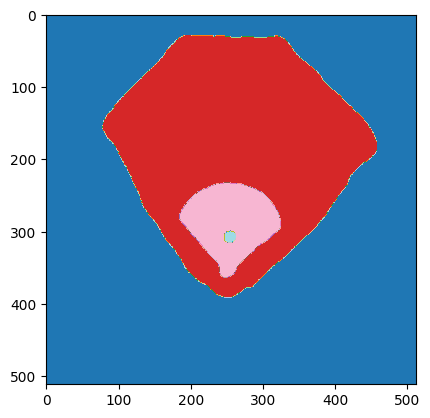

In [16]:

plt.imshow(predictions[0], cmap='tab20')

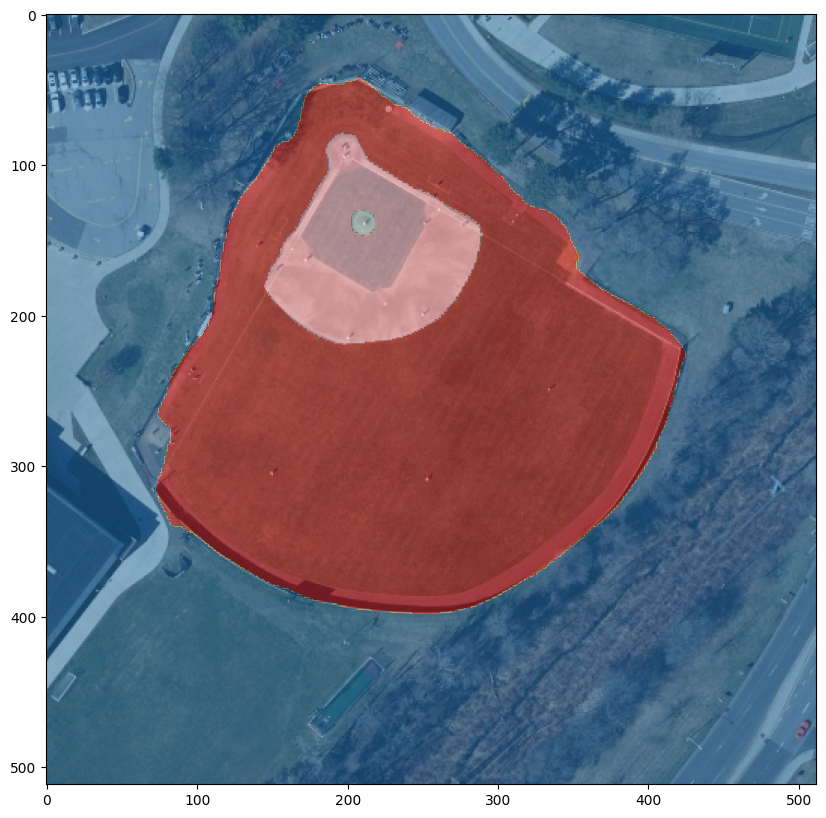

In [17]:
i = 6
fig, ax = plt.subplots(figsize=(10, 10))
field = convert_to_tf_shape(X[~np.array(train_map)])[i]*256
ax.imshow(field)
ax.imshow(predictions[i], cmap='tab20', alpha=0.5)

In [13]:
with open("model2.pkl", "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
print('Done.')

Done.


In [11]:
with open("/kaggle/input/unetmodel/model_12_28_2024.pkl", "rb") as f:
    model = pickle.load(f)
print('Done.')

Done.


In [12]:
torch.save(model.state_dict(), "model_12_28_2024.pth")